## Competition Explanation

- Topic: 스마트 공장의 제어 시스템 구축을 위한 제품 품질 분류 AI 모델 개발

- 평가 산식: Macro F1 Score

- LG Aimers 수료 조건 : Baseline 코드의 Public Score (0.5495720225) 초과

- 논문으로 공개된 베이스의 사전 학습 모델(Pre-trained Model) 사용 가능

* 대회기간 ~ 2023년 02월 28일(화) 10:00


* train.csv
  * PRODUCT_ID : 제품의 고유 ID
  * Y_Class : 제품 품질 상태(Target) \\

     0 : 적정 기준 미달 (부적합)\
1 : 적합\
2 : 적정 기준 초과 (부적합)

  * Y_Quality : 제품 품질 관련 정량적 수치

  * TIMESTAMP : 제품이 공정에 들어간 시각
  
  * LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)

  * PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)

  * X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


* test.csv
 * PRODUCT_ID : 제품의 고유 ID
 * TIMESTAMP : 제품이 공정에 들어간 시각
 * LINE : 제품이 들어간 공정 LINE 종류 ('T050304',  'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
 * PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
 * X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

* sample_submission.csv
 * PRODUCT_ID : 제품의 고유 ID
 * Y_Class : 예측한 제품 품질 상태
  * 0 : 적정 기준 미달 (부적합)\
    1 : 적합\
    2 : 적정 기준 초과 (부적합)

* 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
* 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.


## Import

In [ ]:
import pandas as pd
import random
import os
import numpy as np              # 계산 패키지
# import matplotlib.pyplot as plt  # 데이터 시각화 패키지
# import seaborn as sns           # 데이터 시각화 패키지
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [ ]:
# 추후에 경고 값들을 출력하지 않도록 'ignore'상태로 만들어 준다.
# 불필요한 경고창이 더 이상 출력 되지 않게 됩니다.
warnings.filterwarnings(action = 'ignore')

## Google Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## unzip files

In [ ]:
!unzip /content/drive/MyDrive/Competition/Dacon/23-2_Smart_factory_product_quality_status_classification/open.zip -d /content/

Archive:  /content/drive/MyDrive/Competition/Dacon/23-2_Smart_factory_product_quality_status_classification/open.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      


## Data Load

In [ ]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [ ]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

## Data Pre-processing

### qualitative to quantitative


In [ ]:
# qualitative to quantitative
# 문자를 숫자로 매핑한다.
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()   
    le = le.fit(train_x[i])   # train_x[i]에 fitting -> train_x[i]를 구성하는 element를 정렬 한 다음, 0부터 순서대로 labeling 한다.
    train_x[i] = le.transform(train_x[i])   # 문자를 숫자로 변환한다(Label)
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_:    # le.classes_: LabelEncoder에서 label 0부터 순서대로 매핑된 문자를 element로 갖는다.
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


### 모두 NaN인 열 제거

In [ ]:
train_x.isnull().sum()
# Pandas Series로, index/value로 구성된다.

# isnull(): 관측치가 결측이면 True, 결측이 아니면 False 반환
# isnull().sum(): 각 열에서 몇개의 결측치가 있는 지 count

LINE              0
PRODUCT_CODE      0
X_1             249
X_2             249
X_3             249
               ... 
X_2871          499
X_2872          598
X_2873          598
X_2874          598
X_2875          598
Length: 2877, dtype: int64

In [ ]:
# Pandas Series는 index와 values로 다룰 수 있다.
train_x.isnull().sum().index

Index(['LINE', 'PRODUCT_CODE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_2866', 'X_2867', 'X_2868', 'X_2869', 'X_2870', 'X_2871', 'X_2872',
       'X_2873', 'X_2874', 'X_2875'],
      dtype='object', length=2877)

In [ ]:
train_x.isnull().sum().values

array([  0,   0, 249, ..., 598, 598, 598])

In [ ]:
# 중복제거 후 순서대로 정렬
np.unique(train_x.isnull().sum().values)

array([  0, 249, 250, 349, 350, 351, 365, 423, 424, 469, 478, 479, 480,
       488, 494, 498, 499, 504, 511, 520, 528, 536, 539, 546, 556, 559,
       565, 575, 588, 592, 598])

In [ ]:
# 모두 NaN인 열 제거: 모든 value가 결측치인 열을 imputation 하기 어렵다.
drop_list = []
for i in range(len(train_x.isnull().sum())):
  if train_x.isnull().sum().values[i] == 598:
    drop_list.append(train_x.isnull().sum().index[i])

print(f'drop_list의 개수는 {len(drop_list)}입니다.')

train_x = train_x.drop(drop_list, axis=1)
test_x = test_x.drop(drop_list, axis=1)

drop_list의 개수는 82입니다.


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)

(598, 2795)
(598,)
(310, 2795)


### Imputation
1. 각 열의 평균값으로 fillna
(각 행의 평균값으로 fillna 안됨)
2. 0으로 fillna
3. 각 열의 중간값으로 fillna
4. interpolate 내장함수 + 0으로 fillna

In [ ]:
# 1. 각 열(columns)의 평균값으로 fillna
train_x = train_x.fillna(train_x.mean(axis=0))
test_x = test_x.fillna(train_x.mean(axis=0))

# 각 행(index)의 평균값으로 fillna -> 적용 안됨
# train_x = train_x.fillna(train_x.mean(axis=1))
# test_x = test_x.fillna(train_x.mean(axis=1))

In [ ]:
# 2. 0 으로 fillna
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [ ]:
# 3. 각 열의 중간값으로 fillna
train_x = train_x.fillna(train_x.median())
test_x = test_x.fillna(train_x.median())

In [ ]:
# 4. interpolate 내장함수 + 0으로 fillna
# https://dacon.io/competitions/official/235608/codeshare/1119?page=1&dtype=tag&fType
dst_columns = [k for k in train_x.columns if 'X' in k]
train_dst = train_x[dst_columns]
test_dst = test_x[dst_columns]
train_x[dst_columns] = train_dst.interpolate(axis=1)
train_x = train_x.fillna(0)
test_x[dst_columns] = test_dst.interpolate(axis=1)
test_x = test_x.fillna(0)

In [ ]:
# PRODUCT_CODE으로 구분한 Group 별 가중 평균값으로 fillna
# 같은 날짜(TIMESTAMP), 같은 제품(PRODUCT)를 만들면, 값이 거의 유사하다.

LINE,0,1,2,3,4,5
PRODUCT_CODE,,,,,,
0,59.0,70.0,78.0,42.0,NaN,NaN
1,NaN,NaN,NaN,NaN,3.0,3.0
2,NaN,NaN,NaN,NaN,172.0,171.0


In [ ]:
# NaN를 갖고 있는 열이 없는지 확인
n = 0
for i in train_x.isnull().sum().values:
  if i != 0:
    n+=1
print(n)

n = 0
for i in test_x.isnull().sum().values:
  if i != 0:
    n+=1
print(n)

245
245


## 결측치 시각화

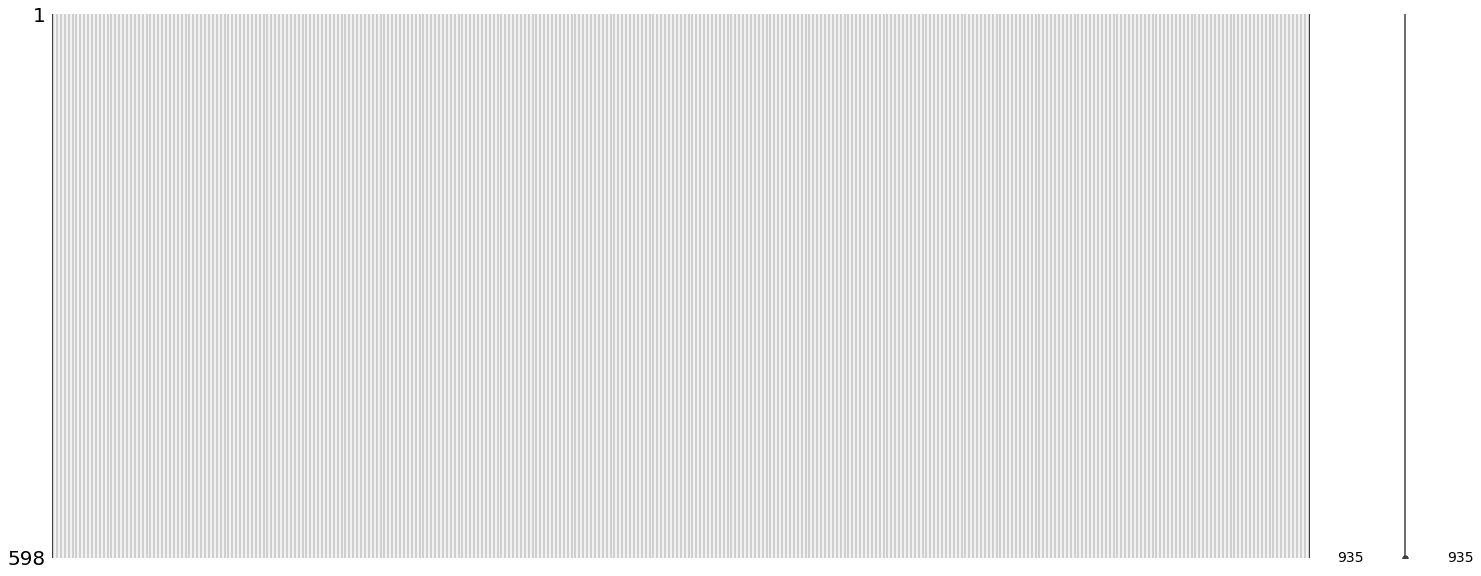

In [ ]:
# 결측치 시각화(x_1~x_935)
import missingno as msno
msno.matrix(train_x.iloc[:, 2:937])    # .iloc[row, column]: Pandas DataFrame에서 특정 행/열을 선택

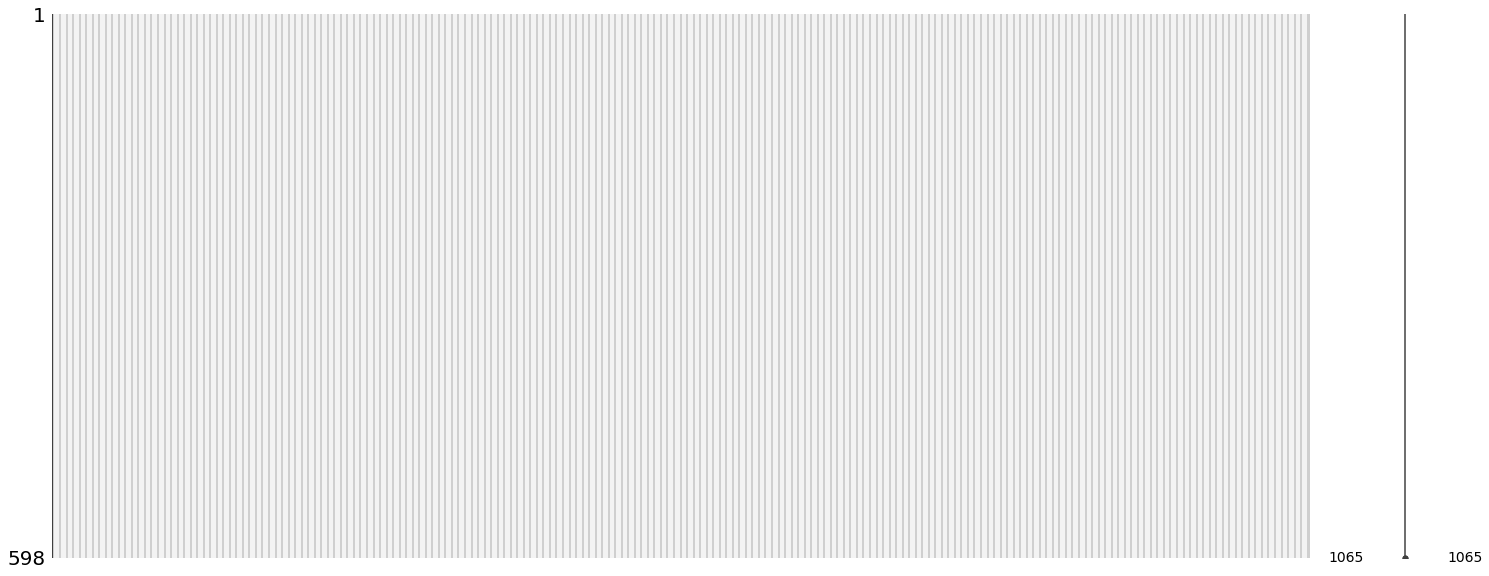

In [ ]:
# 결측치 시각화(x_935~x_2000)
msno.matrix(train_x.iloc[:, 936:2001])

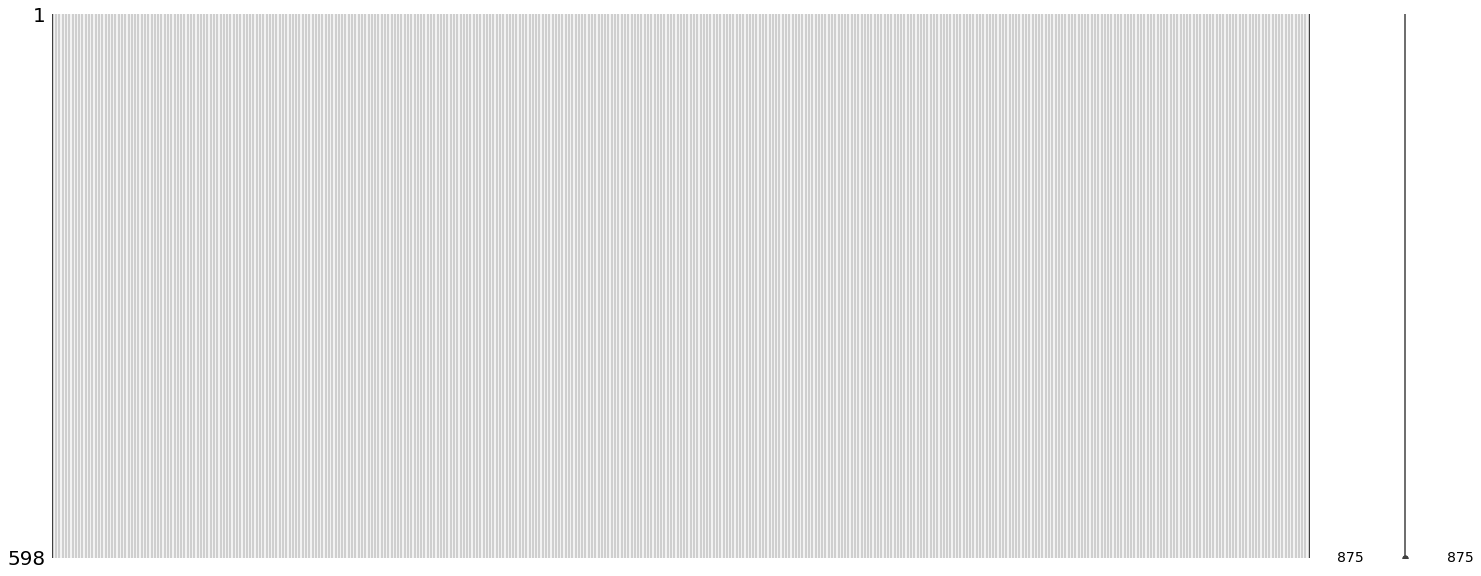

In [ ]:
# 결측치 시각화 x_2001~x_2875
msno.matrix(train_x.iloc[:, 2002:])

## Classification Model Fit

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=37).fit(train_x, train_y)
print('Done.')

Done.


## Inference

In [ ]:
preds = RF.predict(test_x)
print('Done.')

Done.


## Submit

In [ ]:
# csv file을 pandas dataframe으로 읽어온다.
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['Y_Class'] = preds

In [ ]:
submit.to_csv('./각 열의 중간값으로 fillna + 모두 nan인 열 0으로 fillna	', index=False)